# NOTEBOOK MULTICLASS ML INFERENCE USING MODELS TRAINED WITH LESS SAMPLES

## 1. Objectives

This notebook aims to evaluate the performance of classical machine learning models in a multiclass classification setting that have been trained with less samples.  
It uses trained models to predict whether network traffic is normal or belongs to a specific attack type (e.g., XSS, SQL Injection, DDoS...).


## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, model inference, and evaluation.

In [1]:
# numpy and pandas imports
import pandas as pd
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# joblib imports
import joblib as joblib
# sklearn imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 3. SELECT RANDOM SAMPLES WITHOUT BALANCING

In [2]:
# Load dataset
csv_path = "../../data/dataset-csv/DNN-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path, low_memory=False)

# Select the relevant columns
selected_columns = [
    "dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags",
    "tcp.options", "tcp.dstport", "Attack_type"
]
df_selected = df[selected_columns].dropna()

# Sample 21k random samples from the selected data
df_sampled = df_selected.sample(n=21000, random_state=42).reset_index(drop=True)

### 3.1. DATA PREPROCESSING

In [3]:
# Categorical columns to be one-hot encoded
categorical_columns = ["dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags", "tcp.options"]
X = df_sampled.drop(columns=["Attack_type"])
y_true = df_sampled["Attack_type"]

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Load expected columns from the model training phase
expected_columns = joblib.load("../models/models_less_samples/exports/xgb_input_columns.pkl")

# Check for missing columns in the encoded DataFrame
missing_cols = [col for col in expected_columns if col not in X_encoded.columns]

# Create a DataFrame with missing columns filled with zeros
missing_df = pd.DataFrame(0, index=X_encoded.index, columns=missing_cols)

# Concatenate the missing columns DataFrame with the encoded DataFrame
X_encoded = pd.concat([X_encoded, missing_df], axis=1)

# Reorder the columns to match the expected order
X_encoded = X_encoded[expected_columns]

### 3.2. LOAD MODEL

In [4]:
model = joblib.load("../models/models_less_samples/xgboost_model.pkl")
label_encoder = joblib.load("../models/models_less_samples/exports/label_encoder.pkl")
attack_mapping = joblib.load("../models/models_less_samples/exports/attack_mapping.pkl")

### 3.3. MAKE PREDICTIONS

In [5]:
# Make predictions
y_pred_encoded = model.predict(X_encoded)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Save the results in a DataFrame
df_results = pd.DataFrame({
    "true_label": y_true.values,
    "predicted_label": y_pred
})

### 3.4. EVALUATE RESULTS

In [6]:
# Global metrics
accuracy = accuracy_score(df_results["true_label"], df_results["predicted_label"])
precision = precision_score(df_results["true_label"], df_results["predicted_label"], average="weighted", zero_division=0)
recall = recall_score(df_results["true_label"], df_results["predicted_label"], average="weighted", zero_division=0)
f1 = f1_score(df_results["true_label"], df_results["predicted_label"], average="weighted", zero_division=0)

print("Evaluation Results on random 21k Samples")
print(f"- Accuracy :  {accuracy:.4f}")
print(f"- Precision:  {precision:.4f}")
print(f"- Recall   :  {recall:.4f}")
print(f"- F1-score :  {f1:.4f}")

Evaluation Results on random 21k Samples
- Accuracy :  0.8656
- Precision:  0.8534
- Recall   :  0.8656
- F1-score :  0.8470


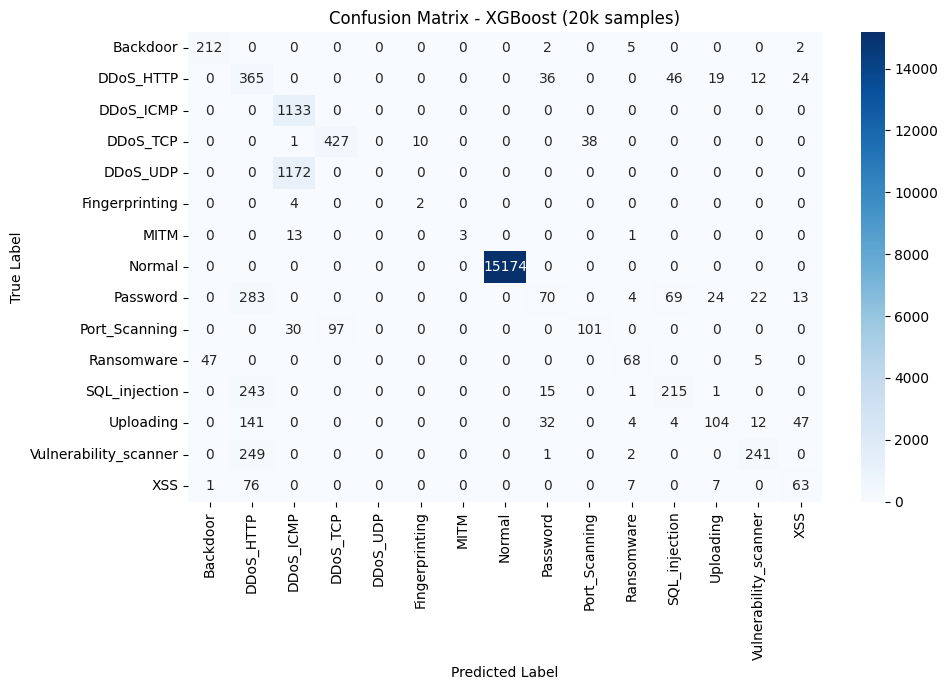

In [7]:
# Confusion matrix
labels = sorted(df_results["true_label"].unique())
cm = confusion_matrix(df_results["true_label"], df_results["predicted_label"], labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost (20k samples)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 4. SELECT RANDOM SAMPLES WITH BALANCING

In [8]:
# Load dataset
csv_path = "../../data/dataset-csv/DNN-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path, low_memory=False)

# Select the relevant columns
selected_columns = [
    "dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags",
    "tcp.options", "tcp.dstport", "Attack_type"
]
df_selected = df[selected_columns].dropna()

# Sample up to 1400 samples per class (balanced sampling) 21k samples approximately
samples_per_class = 1400
attack_classes = df_selected["Attack_type"].unique()

balanced_samples = []

for attack in attack_classes:
    df_attack = df_selected[df_selected["Attack_type"] == attack]
    n_samples = min(samples_per_class, len(df_attack))
    balanced_samples.append(df_attack.sample(n=n_samples, random_state=42))

# Combine and shuffle
df_sampled = pd.concat(balanced_samples).sample(frac=1, random_state=42).reset_index(drop=True)

# Display the number of samples selected and their distribution
print(f"Total samples selected: {len(df_sampled)}")
print(df_sampled["Attack_type"].value_counts())

Total samples selected: 20415
Attack_type
Ransomware               1400
Uploading                1400
Normal                   1400
DDoS_UDP                 1400
XSS                      1400
DDoS_ICMP                1400
Vulnerability_scanner    1400
Backdoor                 1400
Port_Scanning            1400
Password                 1400
DDoS_HTTP                1400
DDoS_TCP                 1400
SQL_injection            1400
MITM                     1214
Fingerprinting           1001
Name: count, dtype: int64


### 4.1. DATA PREPROCESSING

In [9]:
# Categorical columns to be one-hot encoded
categorical_columns = ["dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags", "tcp.options"]
X = df_sampled.drop(columns=["Attack_type"])
y_true = df_sampled["Attack_type"]

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Load expected columns from the model training phase
expected_columns = joblib.load("../models/models_less_samples/exports/xgb_input_columns.pkl")

# Check for missing columns in the encoded DataFrame
missing_cols = [col for col in expected_columns if col not in X_encoded.columns]

# Create a DataFrame with missing columns filled with zeros
missing_df = pd.DataFrame(0, index=X_encoded.index, columns=missing_cols)

# Concatenate the missing columns DataFrame with the encoded DataFrame
X_encoded = pd.concat([X_encoded, missing_df], axis=1)

# Reorder the columns to match the expected order
X_encoded = X_encoded[expected_columns]

### 4.2. LOAD MODEL

In [10]:
model = joblib.load("../models/models_less_samples/xgboost_model.pkl")
label_encoder = joblib.load("../models/models_less_samples/exports/label_encoder.pkl")
attack_mapping = joblib.load("../models/models_less_samples/exports/attack_mapping.pkl")


### 4.3. MAKE PREDICTIONS

In [11]:
# Make predictions
y_pred_encoded = model.predict(X_encoded)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Save the results in a DataFrame
df_results = pd.DataFrame({
    "true_label": y_true.values,
    "predicted_label": y_pred
})

### 4.4. EVALUATE RESULTS

In [12]:
# Global metrics
accuracy = accuracy_score(df_results["true_label"], df_results["predicted_label"])
precision = precision_score(df_results["true_label"], df_results["predicted_label"], average="weighted", zero_division=0)
recall = recall_score(df_results["true_label"], df_results["predicted_label"], average="weighted", zero_division=0)
f1 = f1_score(df_results["true_label"], df_results["predicted_label"], average="weighted", zero_division=0)

print("Evaluation Results on random balanced 21k Samples approx. 1400 per class")
print(f"- Accuracy :  {accuracy:.4f}")
print(f"- Precision:  {precision:.4f}")
print(f"- Recall   :  {recall:.4f}")
print(f"- F1-score :  {f1:.4f}")

Evaluation Results on random balanced 21k Samples approx. 1400 per class
- Accuracy :  0.5372
- Precision:  0.6362
- Recall   :  0.5372
- F1-score :  0.5169


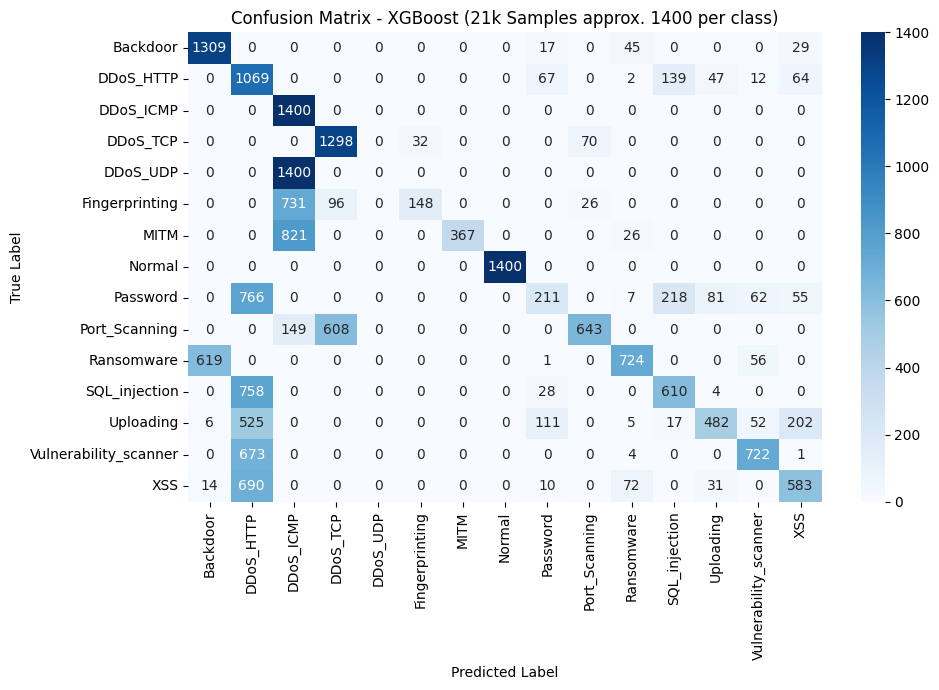

In [13]:
# Confusion matrix
labels = sorted(df_results["true_label"].unique())
cm = confusion_matrix(df_results["true_label"], df_results["predicted_label"], labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost (21k Samples approx. 1400 per class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()